In [2]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import lhsmdu

%matplotlib inline

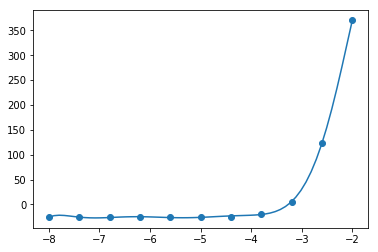

In [6]:
w0=[-25.707735, -25.710188, -25.709892, -25.706526, -25.693748, -25.55207, -24.482933, -18.821348, \
    5.002062, 123.48782, 370.23325]
logM_env=np.linspace(-8,-2,11)
p=np.flip(np.polyfit(logM_env,w0,8))

def polyout(x):
    out=0
    for i in range(len(p)):
        out+=p[i]*(x**i)
    return out

plt.scatter(logM_env,w0)
x=np.linspace(-8,-2,60)
plt.plot(x,polyout(x))
plt.show()

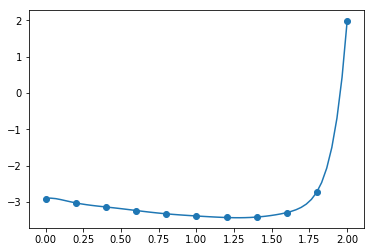

In [60]:
w0=[-2.9086766, -3.0266216, -3.1385906, -3.2380328, -3.3243818, -3.3912644, \
    -3.427059 , -3.4192274, -3.2926285, -2.7189488, 1.9932499]
gamma=np.linspace(0,2,11)
p=np.flip(np.polyfit(gamma,w0,9))

def polyout(x):
    out=3.5
    for i in range(len(p)):
        out+=p[i]*(x**i)
    return out

plt.scatter(gamma,w0)
x=np.linspace(0,2,60)
plt.plot(x,polyout(x)-3.5)
plt.show()

In [61]:
r=[[0,2],[0,2]]
x=np.array(lhsmdu.sample(2,80))
x=x*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
x+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

with open('../grid_metadata/2dex_coords.txt', 'wb') as fp:
    pickle.dump(np.transpose(x), fp)

with open ('../grid_metadata/2dex_coords.txt', 'rb') as fp:
    x = pickle.load(fp)

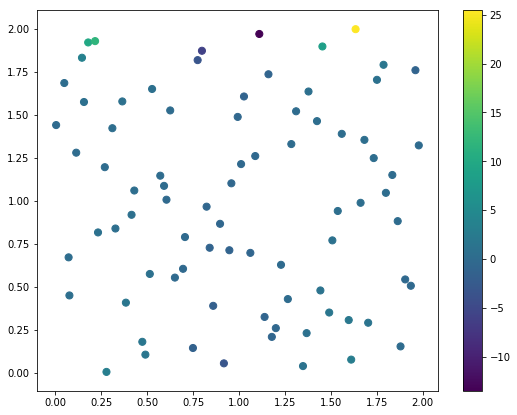

Initial ln-likelihood: -5399.43
[ 2.04411203 -2.40794561  0.69314718]
[2.77890236 0.3        1.41421356]


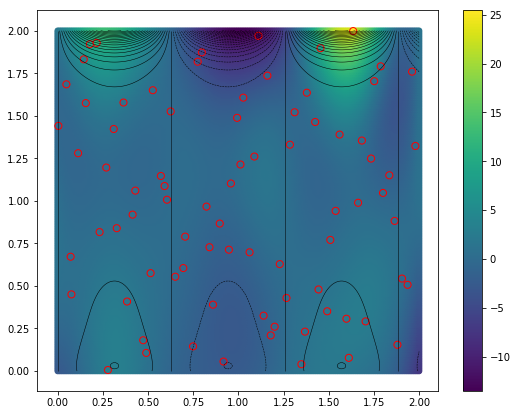

In [62]:
np.random.seed(250)
yerr=0.1*np.ones_like(x[:,0])
y=5*np.sin(5*x[:,0])*polyout(x[:,1]) + yerr*np.random.randn(len(x))

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(y), vmax=np.max(y))
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
plt.colorbar()
plt.show()

#kernel = np.var(y) * kernels.ExpSquaredKernel(0.3**2,ndim=2,axes=0)* kernels.PolynomialKernel(1.7,15,ndim=2,axes=1)
kernel = np.var(y) * kernels.ExpSquaredKernel(0.3**2,ndim=2,axes=0)* kernels.ExpSquaredKernel(2,ndim=2,axes=1)
gp = george.GP(kernel)
gp.compute(x,yerr)

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

x0pred,x1pred=np.meshgrid(np.linspace(0, 2, 200),np.linspace(0, 2, 200))
x_pred=list(map(lambda x, y:(x,y), np.ndarray.flatten(x0pred), np.ndarray.flatten(x1pred)))
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(y), vmax=np.max(y))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.contour(x0pred,x1pred,5*np.sin(5*x0pred)*polyout(x1pred),levels=40,colors='k',linewidths=0.5)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style,edgecolors='r')
plt.show()

      fun: 217.07093283419988
 hess_inv: array([[ 2.56986874e-02, -3.09990706e+01,  2.39966020e-02],
       [-3.09990706e+01,  2.16754996e+08,  2.93040801e+02],
       [ 2.39966020e-02,  2.93040801e+02,  8.39186705e-02]])
      jac: array([ 0.00000916, -0.        , -0.00000786])
  message: 'Optimization terminated successfully.'
     nfev: 61
      nit: 57
     njev: 61
   status: 0
  success: True
        x: array([ 2.06068507, 22.48251933, -8.92793892])

Final ln-likelihood: -217.07
[ 2.06068507 22.48251933 -8.92793892]
[    2.80202546 76210.89135854     0.01151656]


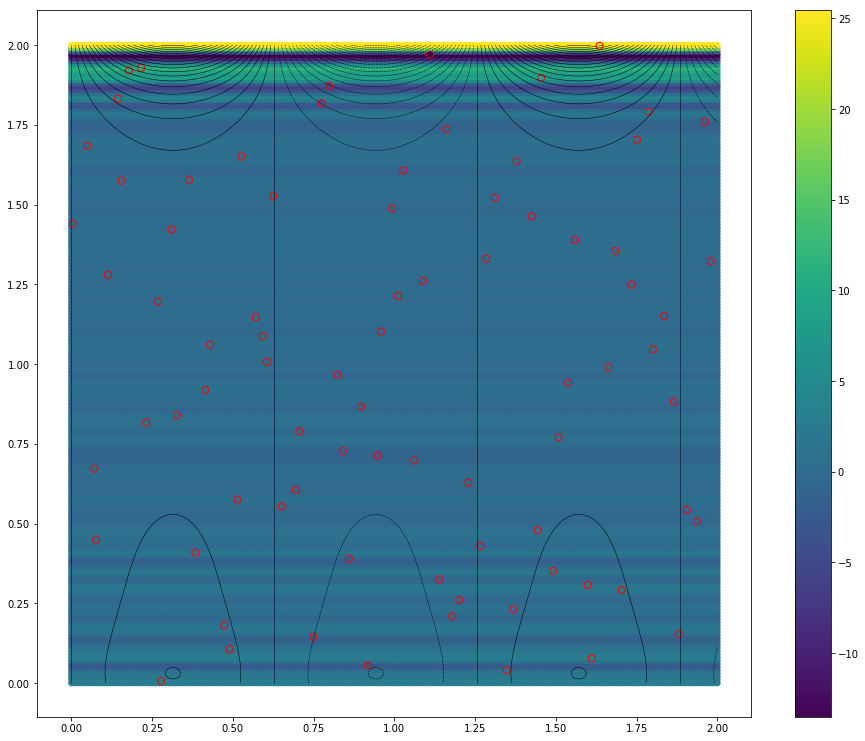

In [63]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
np.set_printoptions(suppress=True)

print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(16,13))
style = dict(cmap='viridis', vmin=np.min(y), vmax=np.max(y))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.contour(x0pred,x1pred,5*np.sin(5*x0pred)*polyout(x1pred),levels=40,colors='k',linewidths=0.5)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style,edgecolors='r')
plt.show()

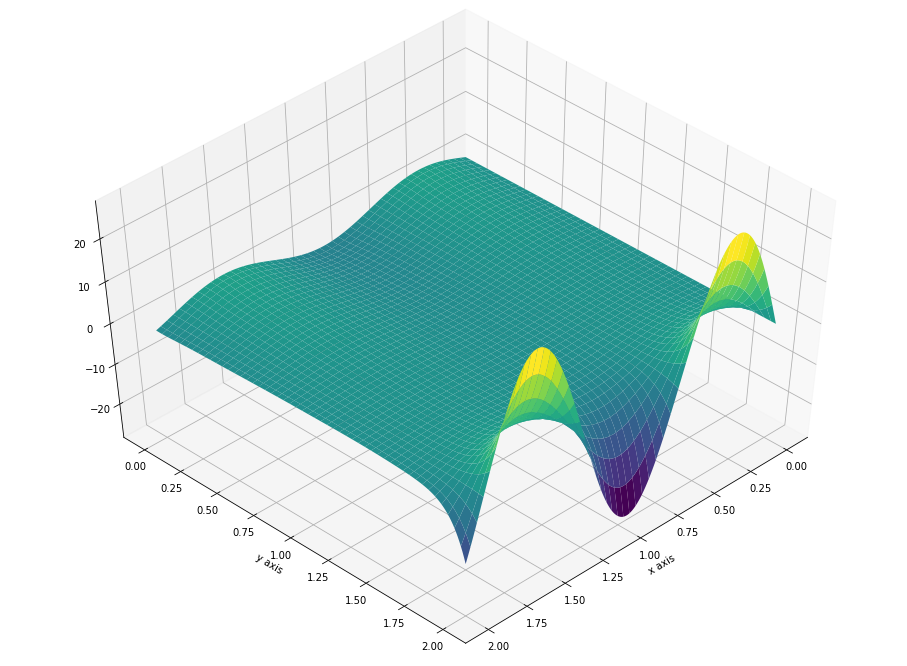

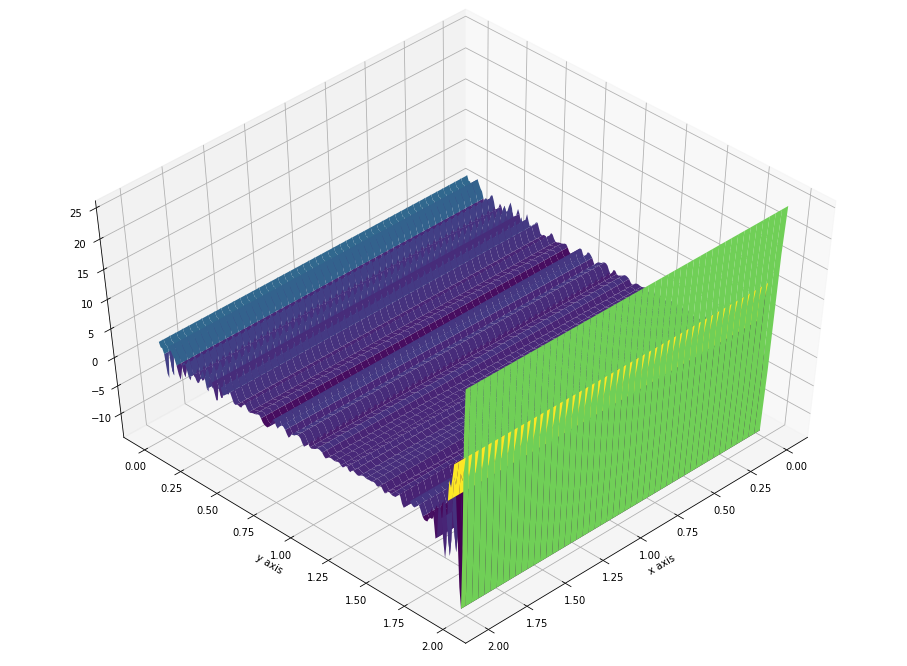

In [64]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surf = ax.plot_surface(x0pred,x1pred,5*np.sin(5*x0pred)*polyout(x1pred),cmap=cm.viridis)
ax.set_ylabel("y axis")
ax.set_xlabel("x axis")
ax.view_init(50, 45)
plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surfgp = ax.plot_surface(x0pred,x1pred,pred.reshape(200,200),cmap=cm.viridis)

ax.set_ylabel("y axis")
ax.set_xlabel("x axis")

ax.view_init(50, 45)
plt.show()

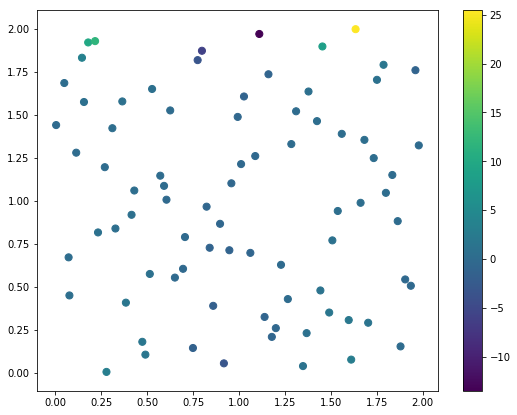

Initial ln-likelihood: -1057.56
[ 2.04411203 -2.40794561  1.7       ]
[2.77890236 0.3        2.33964685]


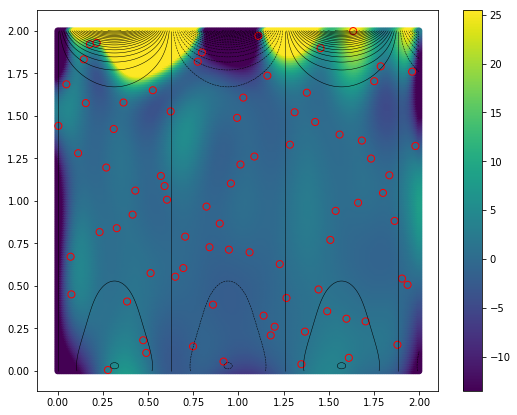

In [66]:
np.random.seed(250)
yerr=0.1*np.ones_like(x[:,0])
y=5*np.sin(5*x[:,0])*polyout(x[:,1]) + yerr*np.random.randn(len(x))

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(y), vmax=np.max(y))
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
plt.colorbar()
plt.show()

kernel = np.var(y) * kernels.ExpSquaredKernel(0.3**2,ndim=2,axes=0)* kernels.PolynomialKernel(1.7,15,ndim=2,axes=1)
#kernel = np.var(y) * kernels.ExpSquaredKernel(0.3**2,ndim=2,axes=0)* kernels.ExpSquaredKernel(2,ndim=2,axes=1)
gp = george.GP(kernel)
gp.compute(x,yerr)

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

x0pred,x1pred=np.meshgrid(np.linspace(0, 2, 200),np.linspace(0, 2, 200))
x_pred=list(map(lambda x, y:(x,y), np.ndarray.flatten(x0pred), np.ndarray.flatten(x1pred)))
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(y), vmax=np.max(y))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.contour(x0pred,x1pred,5*np.sin(5*x0pred)*polyout(x1pred),levels=40,colors='k',linewidths=0.5)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style,edgecolors='r')
plt.show()

      fun: 102.22301708271561
 hess_inv: array([[ 1.13133209,  0.15357515, -0.07042538],
       [ 0.15357515,  0.05463956, -0.00711337],
       [-0.07042538, -0.00711337,  0.00492316]])
      jac: array([-0.00004016, -0.00008023, -0.00041325])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 143
      nit: 16
     njev: 130
   status: 2
  success: False
        x: array([-24.68421372,  -2.28078542,   1.66372992])

Final ln-likelihood: -102.22
[-24.68421372  -2.28078542   1.66372992]
[0.00000436 0.31969345 2.29759968]


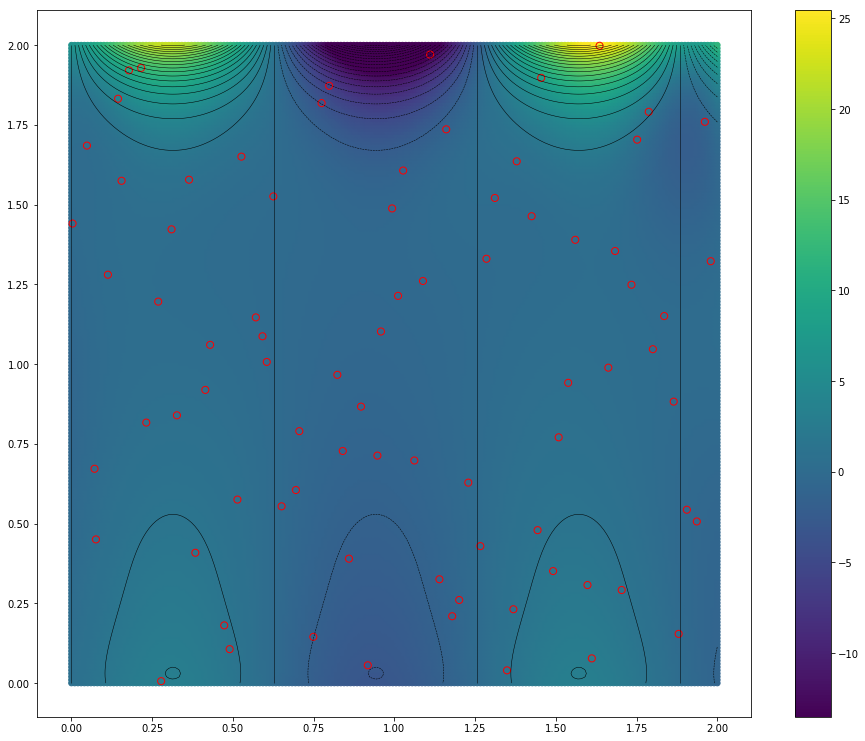

In [67]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
np.set_printoptions(suppress=True)

print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(16,13))
style = dict(cmap='viridis', vmin=np.min(y), vmax=np.max(y))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.contour(x0pred,x1pred,5*np.sin(5*x0pred)*polyout(x1pred),levels=40,colors='k',linewidths=0.5)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style,edgecolors='r')
plt.show()

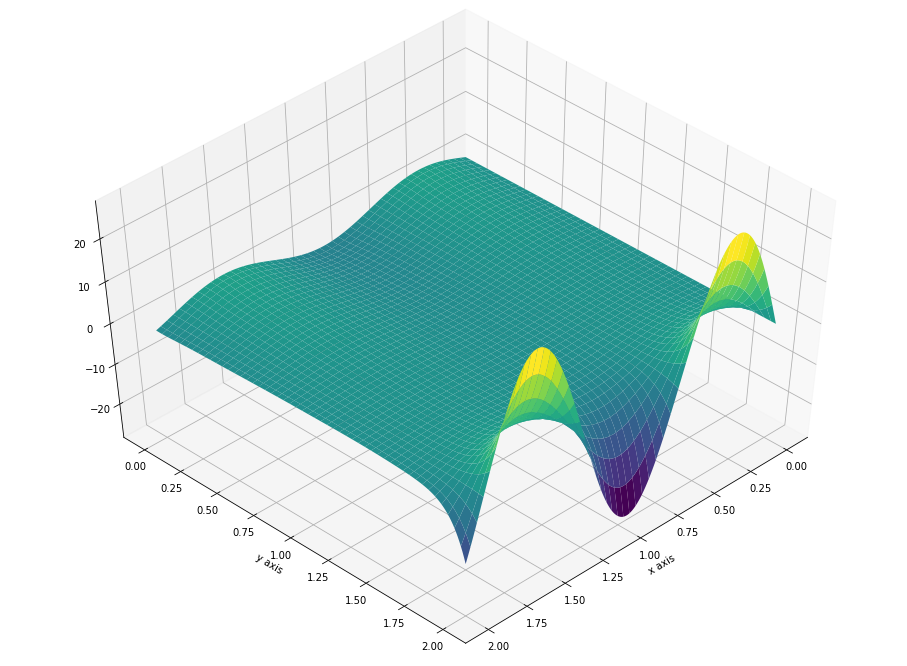

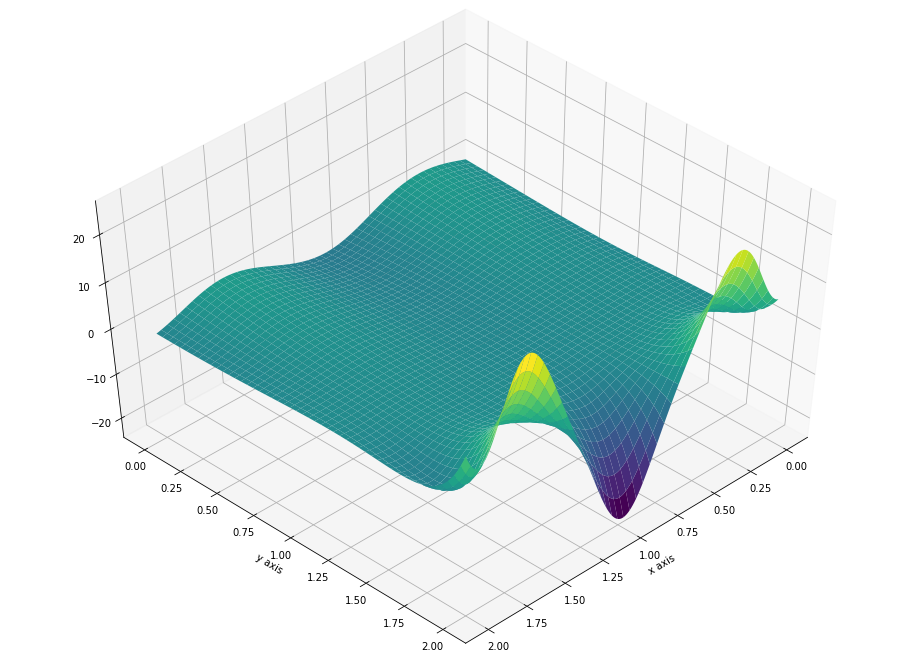

In [68]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surf = ax.plot_surface(x0pred,x1pred,5*np.sin(5*x0pred)*polyout(x1pred),cmap=cm.viridis)
ax.set_ylabel("y axis")
ax.set_xlabel("x axis")
ax.view_init(50, 45)
plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surfgp = ax.plot_surface(x0pred,x1pred,pred.reshape(200,200),cmap=cm.viridis)

ax.set_ylabel("y axis")
ax.set_xlabel("x axis")

ax.view_init(50, 45)
plt.show()

In [65]:
def sedcomp_anim(model,ds,ncomp=40,nfeat=500):
    
    fig,ax= plt.subplots(figsize=(12,9))
    ax.plot(np.log10(xvals)[0:nfeat], cubes[ds][model][0:nfeat], c='black',label="pdspy SED")
        
    coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1)) 
    reconst=[]
    for j in range(ncomp):
        reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[ds][0:j+1,0:nfeat]) +\
                       pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model]))
    
    line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')
    
    def animate(i):
        label="number of components = {0}".format(int(i//1))
        line.set_ydata(reconst[int(i//1)])
        ax.set_xlabel("log of λ (μm)",fontsize=16)
        ax.set_ylabel("log of Flux Density (mJy)",fontsize=16)
        ax.set_title("reconstructed SED of "+str(sizes[ds])+" model #"+str(model)+" against pdspy SED, ncomp="+str(int(i//1)+1))
        return line,ax

    anim=FuncAnimation(fig,animate,frames=np.arange(0,ncomp,0.25),interval=1)
    anim.save("../visualization/comp_sets/sedcomp_"+str(sizes[ds])+"_m"+str(model)+"_nc"+str(ncomp)+".gif", dpi=72, writer="imagemagick")